# Geometric Tensor Learning
---

In [1]:
import numpy as np
import numpy.ma as ma
from numpy.linalg import norm
import matplotlib.pyplot as plt
import networkx as nx

import project_path

from util.t2m import t2m
from util.m2t import m2t
from util.update_L_nograd import update_L
from util.update_L_nograd import fn_val as fnval_L
from util.update_X_nograd import update_X
from util.update_X_nograd import fn_val as fnval_X
from util.update_Sigma import update_Sigma
from util.update_Lambda_nograd import update_Lambda
from util.update_Sigma import fn_val as fnval_Sigma
from util.generate_data import generate_syn_data
from util.contaminate_data import contaminate_signal

In [2]:
def fn_val_G(G, L, Phi, Lambda, alpha, gamma):
    n = len(G)
    val_smooth = [gamma[i]*np.trace(t2m(G[i],i).transpose() @ Phi[i] @ t2m(G[i],i)) for i in range(n)]
    val_Lag = [alpha[i]*norm(L-G[i]-Lambda[i])**2 for i in range(n)]
    fn_val = sum(val_smooth) + sum(val_Lag)
    return fn_val, val_smooth, val_Lag

def fn_val_L(L, Y, Lx, G, Lambda, alpha):
    n = len(L.shape)
    val_Y = norm(Y[~Y.mask]-L[~Y.mask])**2
    val_Lag1 = [alpha[0][i]*norm(L-G[i]-Lambda[0][i])**2 for i in range(n)]
    val_Lag2 = [alpha[1][i]*norm(L-Lx[i]-Lambda[1][i])**2 for i in range(n)]
    fn_val = val_Y + sum(val_Lag1) + sum(val_Lag2)
    return fn_val, val_Y, val_Lag1, val_Lag2

In [3]:
sizes = (10,10,10,10)
n = len(sizes)

In [4]:
G = [nx.erdos_renyi_graph(sizes[i],0.3) for i in range(n)] # List of graphs for each mode
Phi = [nx.laplacian_matrix(G[i]).todense() for i in range(n)]


In [5]:
def graph_filter(Lambda, filter_length=3):
    ''' Graph filter generating the graph stationary data.
    '''
    h = np.random.rand(filter_length)
    return sum(h[i]**i*Lambda**i for i in range(filter_length))

In [6]:
# Generate data smooth in Cartesian graph G.
ranks = (3,3,3,3)
# X_smooth = generate_syn_data(sizes, ranks)
# V_all = 1

covs = []
X_smooth = np.zeros(sizes)
for i in range(n):
    W, V = np.linalg.eigh(Phi[i])
    eigs = graph_filter(W)
    H = V@np.diag(eigs)@V.transpose()
    covs.append(H @ H)

    col_inds = np.setdiff1d(np.arange(n), 1)
    sz = np.array(sizes)
    sz_cols = np.prod(sz[col_inds])
    mean_temp = np.zeros(Phi[i].shape[0])
    Xmat = np.random.multivariate_normal(mean_temp, covs[i], sz_cols).transpose()
    X_smooth = X_smooth + m2t(Xmat, sizes, i)

    # if not(i):
    #     W_all = W
    # else:
    #     W_all = np.kron(np.ones(W.size), W_all) + np.kron(W,np.ones(W_all.size).flatten('F'))
    # V_all = np.kron(V_all, V)

# X_stat = np.tensordot(H, np.random.randn(H.shape[1]), axes=([1],[0])).reshape(sizes)
# del W_all, V_all, H, eigs

Y = contaminate_signal(X_smooth, target_SNR=15)

In [7]:
def initialize_nograd(n, sizes):
    # Parameters
    alpha = [[10**-2 for i in range(n)], 
        [10**-2 for i in range(n)], 
        [10**-2 for i in range(n)], 
        [10**-4 for i in range(n)]]
    theta = [10**-4 for i in range(n)]
    gamma = [.001 for i in range(n)]

    # Initializations
    L = np.zeros(sizes)
    G_var = [np.zeros(sizes) for i in range(n)]
    X = [np.zeros(sizes) for i in range(n)]
    Lx = [np.zeros(sizes) for i in range(n)]
    Sigma = []
    for i in range(n):
        temp = np.random.standard_normal(sizes[i]**2).reshape([sizes[i], sizes[i]])
        Sigma.append(temp@temp.transpose())

    Lambda = [[np.zeros(sizes) for i in range(n)],
        [np.zeros(sizes) for i in range(n)],
        [np.zeros(sizes) for i in range(n)],
        [np.zeros([sizes[i],sizes[i]]) for i in range(n)]]
    
    return L, G_var, Lx, X, Sigma, Lambda, alpha, theta, gamma

In [8]:
L, G_var, Lx, X, Sigma, Lambda, alpha, theta, gamma = initialize_nograd(n, sizes)

In [9]:
G_inv = [np.linalg.inv(gamma[i]*Phi[i] + alpha[0][i]*np.identity(sizes[i])) for i in range(n)]
iter = 0
fval_tot = []
# ADMM Loop
while True:
    # L Update
    prev_val = fn_val_L(L, Y, Lx, G_var, Lambda[:2], alpha[:2])[0]
    temp = np.zeros(sizes)
    for i in range(n):
        temp += alpha[0][i]*(G_var[i] + Lambda[0][i])
        temp += alpha[1][i]*(Lx[i] + Lambda[1][i])
    L = temp/(sum(alpha[0]) + sum(alpha[1]))
    L[~Y.mask] = L[~Y.mask] + Y[~Y.mask]/(sum(alpha[0]) + sum(alpha[1]) + 1)
    fval_data = fn_val_L(L, Y, Lx, G_var, Lambda[:2], alpha[:2])
    fval_data_change = fval_data[0]-prev_val
    
    # G Update
    prev_val = fn_val_G(G_var, L, Phi, Lambda[0], alpha[0], gamma)[0]
    G_var = [m2t(alpha[0][i]*G_inv[i]*t2m(L-Lambda[0][i], i), sizes, i) for i in range(n)]
    fval_G = fn_val_G(G_var, L, Phi, Lambda[0], alpha[0], gamma)
    fval_G_change = fval_G[0] - prev_val

    # Lx Update
    prev_val = fnval_L(Lx, L, X, Lambda[1:], Sigma, alpha[1:])[0]
    Lx, fval_L, fval_low, _, _ = update_L(Lx, L, X, Lambda[1:], Sigma, alpha[1:], track_fval=True)
    fval_L_change = fval_L - prev_val

    # X Update
    prev_val = sum(fnval_X(X,Lx,Lambda[2:],Sigma,alpha[2:])[1])
    X, _, fval_X, _ = update_X(X, Lx, Lambda[2:], Sigma, alpha[2:], track_fval=True)
    fval_X_change = sum(fval_X) - prev_val

    # Sigma Update 
    prev_val = fnval_Sigma(Sigma, Lx, X, Phi, Lambda[3], alpha[3], theta)[0]
    Sigma, fval_Sigma, _, _ = update_Sigma(Sigma, Lx, X, Phi, Lambda[3], alpha[3], theta, track_fval=True)
    fval_Sigma_change = fval_Sigma - prev_val
    
    fval_tot.append(fval_data[1] + fval_G[0] + sum(fval_low) + sum(fval_X) + fval_Sigma)
    print('Objective function changes for L: {:.2e}, G: {:.2e}, Lx: {:.2e}, X: {:.2e}, Sigma: {:.2e}'.format(
        fval_data_change,
        fval_G_change,
        fval_L_change,
        fval_X_change,
        fval_Sigma_change
    ))
    print('Total Objective Function Value at iter {}: {}'.format(iter, fval_tot[-1]))
    # Dual Update
    Lambda = update_Lambda(Lambda,L,Lx,X,G_var,Sigma)[0]
    if iter%1000==999:
        break
    iter += 1

Objective function changes for L: -6.04e+06, G: -1.70e+05, Lx: -1.12e+05, X: -8.79e+01, Sigma: -4.33e+01
Total Objective Function Value at iter 0: 201457.04204254516
Objective function changes for L: 3.63e+05, G: -4.18e+04, Lx: -7.94e+03, X: -3.01e+02, Sigma: -1.28e+02
Total Objective Function Value at iter 1: 901014.8351687052
Objective function changes for L: -2.78e+05, G: -1.27e+03, Lx: -2.00e+03, X: -8.62e+02, Sigma: -3.57e+02
Total Objective Function Value at iter 2: 1471318.4169312317
Objective function changes for L: 6.29e+04, G: -1.75e+04, Lx: -1.20e+04, X: -5.44e+03, Sigma: -1.06e+03
Total Objective Function Value at iter 3: 2498592.3226860706
Objective function changes for L: 1.49e+06, G: -3.21e+04, Lx: -1.61e+04, X: -1.90e+04, Sigma: -4.42e+03
Total Objective Function Value at iter 4: 4733703.691752548
Objective function changes for L: 2.48e+06, G: -2.99e+04, Lx: -9.31e+03, X: -3.05e+05, Sigma: -2.10e+04
Total Objective Function Value at iter 5: 7312508.95824291
Objective fu

In [10]:
norm(X_smooth-L)/norm(X_smooth)

0.5004592996005507

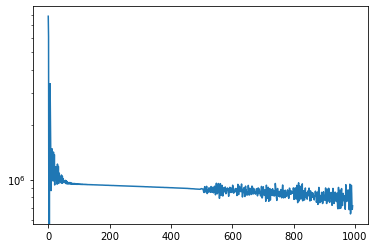

In [11]:
plt.semilogy(fval_tot[7:]-min(fval_tot[7:]))
plt.show()

In [12]:
norm(X_smooth-Y.data)/norm(X_smooth)

0.17824364395464812

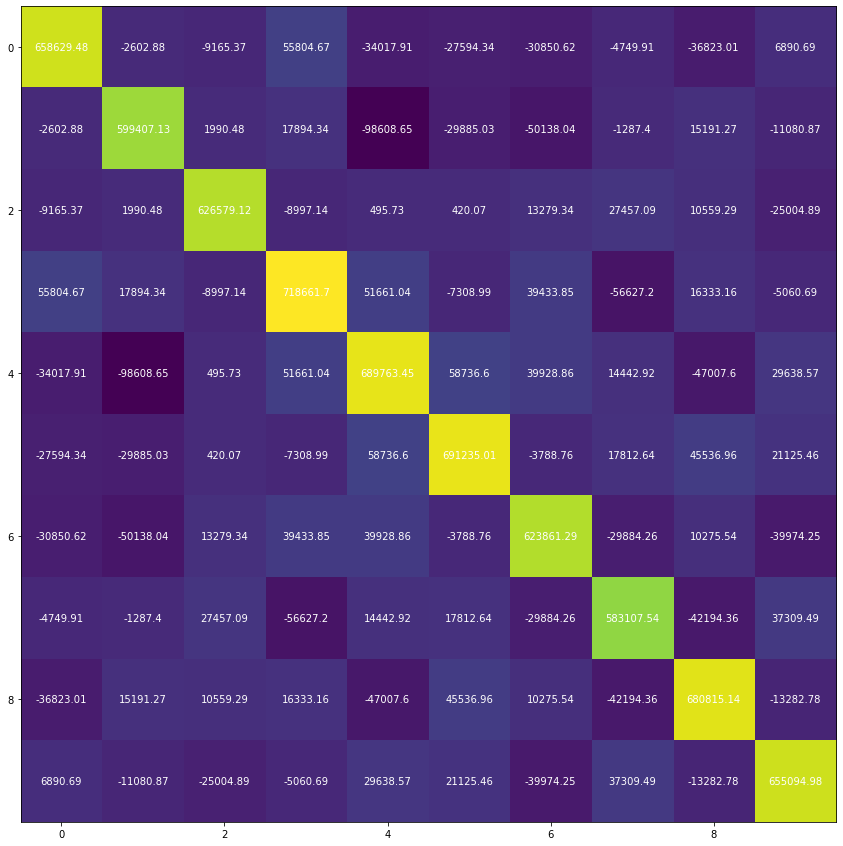

In [13]:
Ymat = t2m(Y.data, 0)
cov = Ymat@Ymat.transpose()

fig, ax = plt.subplots(figsize = (15,15))
im = ax.imshow(cov)

for i in range(cov.shape[0]):
    for j in range(cov.shape[1]):
        text = ax.text(j, i, np.round(cov[i, j], 2) ,
                       ha="center", va="center", color="w")